## Import libraries


In [29]:
import os
import sys
import time

source_folder = "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/src"
sys.path.append(source_folder)

import numpy as np
import torch
from dataset.dataset import CropFusionNetDataset
from loss.loss import QuantileLoss
from models.AttnLSTM.model import AttnLSTM
from models.ResCNN.model import ResCNN
from models.SimpleTransformer.model import SimpleTransformer
from models.VanillaLSTM.model import VanillaLSTM
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from utils.utils import set_seed, evaluate_and_save_outputs, load_config, save_config

# Crop
crop = "winter_barley"
cfg, model_config, train_config = load_config(crop)

device = model_config["device"]
set_seed(42)
baseline_model_name = "ResCNN"

## Create datasets and dataloader


In [30]:
train_dataset = CropFusionNetDataset(cfg, mode="train", scale=True)
val_dataset = CropFusionNetDataset(cfg, mode="val", scale=True)
test_dataset = CropFusionNetDataset(cfg, mode="test", scale=True)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_config["batch_size"],
    shuffle=True,
    num_workers=32,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_config["batch_size"],
    shuffle=False,
    num_workers=32,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=train_config["batch_size"],
    shuffle=False,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

## Load the best model


In [31]:
model = ResCNN(model_config).to(device)
checkpoint_path = f"/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/src/train/baseline/winter_barley/Jul/{baseline_model_name}/best_model.pt"
assert os.path.exists(checkpoint_path), f"❌ No checkpoint found at {checkpoint_path}"
model.load_state_dict(
    torch.load(checkpoint_path, map_location=device, weights_only=True)
)
model.eval()
print(f"✅ Loaded pretrained model from {checkpoint_path}")
criterion = QuantileLoss(quantiles=model_config["quantiles"]).to(device)

✅ Loaded pretrained model from /beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/src/train/baseline/winter_barley/Jul/ResCNN/best_model.pt


## Run inference


In [32]:
import torch
import numpy as np
import pickle
import os
from tqdm import tqdm
from collections import defaultdict


def run_inference(
    model, test_loader, device, criterion=None, output_path="inference_results.pkl"
):
    """
    Runs inference on CropFusionNet, capturing predictions, targets, and attention weights.
    """
    model.eval()

    # Storage for all batches
    results_buffer = defaultdict(list)

    print(f"🚀 Starting inference on {device}...")

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Inference"):

            # 1. Prepare Inputs
            inputs = {
                "inputs": batch["inputs"].to(device),
                "identifier": batch["identifier"].to(device),
                "mask": batch["mask"].to(device),
                "variable_mask": (
                    batch.get("variable_mask").to(device)
                    if batch.get("variable_mask") is not None
                    else None
                ),
            }
            targets = batch["target"].to(device)

            # 2. Forward Pass
            output_dict = model(inputs)

            preds = output_dict["prediction"]

            # 3. Calculate Loss
            if criterion:
                loss = criterion(preds, targets)
                results_buffer["batch_loss"].append(loss.item())

            # 4. Store Core Outputs
            results_buffer["prediction"].append(preds.cpu().numpy())
            results_buffer["target"].append(targets.cpu().numpy())

            # 5. Store Interpretability Weights
            if "static_weights" in output_dict:
                results_buffer["static_weights"].append(
                    output_dict["static_weights"].cpu().numpy()
                )

            if "temporal_weights" in output_dict:
                results_buffer["temporal_weights"].append(
                    output_dict["temporal_weights"].cpu().numpy()
                )

            if "attention_weights" in output_dict:
                results_buffer["attention_weights"].append(
                    output_dict["attention_weights"].cpu().numpy()
                )

            # 6. Store Metadata
            if "NUTS_ID" in batch:
                results_buffer["NUTS_ID"].extend(batch["NUTS_ID"])
            if "year" in batch:
                results_buffer["year"].extend(batch["year"])

    # 7. Consolidate Results
    print("📦 Consolidating results...")
    final_results = {}

    for key, val_list in results_buffer.items():
        if key in ["batch_loss", "NUTS_ID", "year"]:
            final_results[key] = np.array(val_list)
        else:
            try:
                final_results[key] = np.concatenate(val_list, axis=0)
            except ValueError as e:
                print(
                    f"⚠️ Warning: Could not concatenate '{key}'. Saving as list. ({e})"
                )
                final_results[key] = val_list

    # 8. Save to Disk
    if output_path:
        os.makedirs(
            os.path.dirname(output_path) if os.path.dirname(output_path) else ".",
            exist_ok=True,
        )

        with torch.serialization.safe_globals([np.ndarray]):
            with open(output_path, "wb") as f:
                pickle.dump(final_results, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"💾 Results saved to {output_path}")

    return final_results

In [35]:
results = run_inference(model, val_loader, device, criterion)

# Load the results
# with open("results/test_inference_66.pkl", "rb") as f:
#     results = pickle.load(f)

🚀 Starting inference on cuda...


Inference: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

📦 Consolidating results...
💾 Results saved to inference_results.pkl


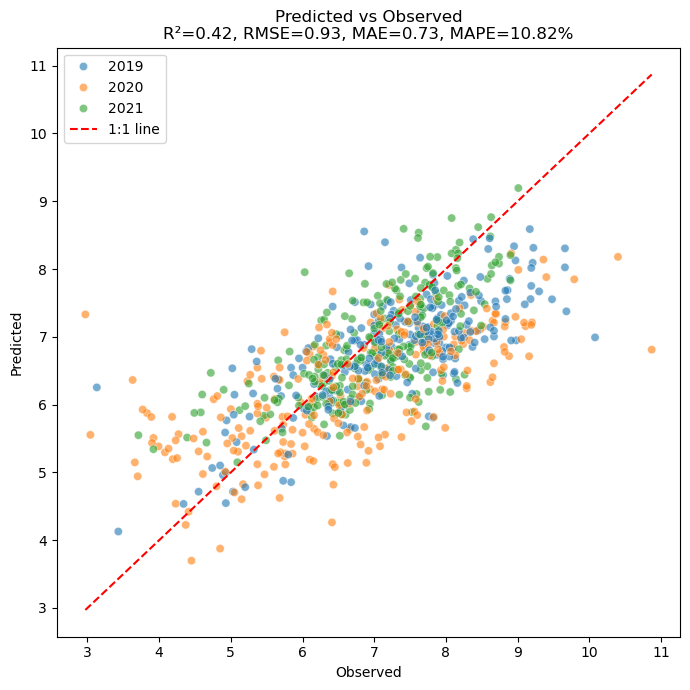

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import numpy as np

# Extract true and predicted values
y_true = results["target"] * test_dataset.target_std + test_dataset.target_mean
y_pred = (
    results["prediction"][:, 1] * test_dataset.target_std + test_dataset.target_mean
)

# Compute metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Scatter plot
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_true, y=y_pred, hue=results["year"], palette="tab10", alpha=0.6)
plt.plot(
    [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="1:1 line"
)  # 1:1 line

# Labels and title
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title(
    f"Predicted vs Observed\nR²={r2:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2%}"
)
plt.legend()
plt.tight_layout()
plt.show()

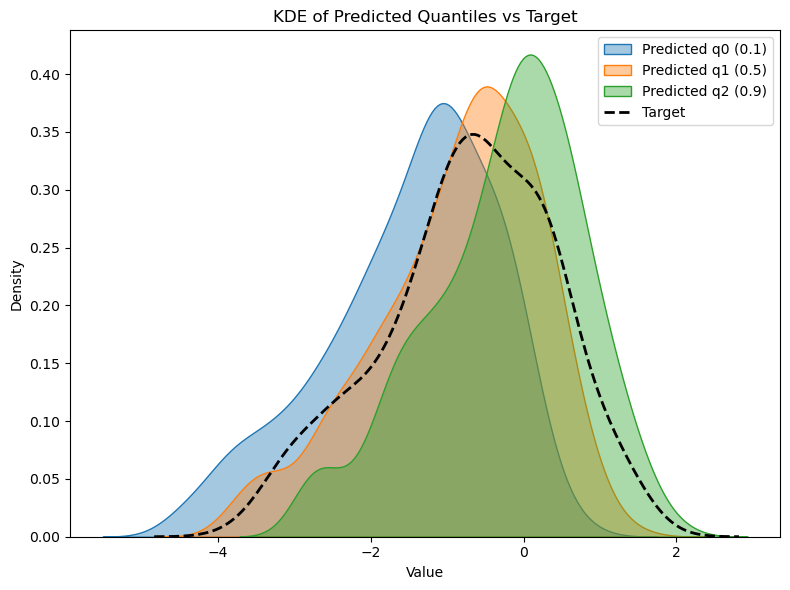

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract predicted quantiles
q0 = results["prediction"][:, 0]
q1 = results["prediction"][:, 1]
q2 = results["prediction"][:, 2]
y_true = results["target"]

plt.figure(figsize=(8, 6))

# KDE for each quantile
sns.kdeplot(q0, label="Predicted q0 (0.1)", fill=True, alpha=0.4)
sns.kdeplot(q1, label="Predicted q1 (0.5)", fill=True, alpha=0.4)
sns.kdeplot(q2, label="Predicted q2 (0.9)", fill=True, alpha=0.4)

# KDE for target
sns.kdeplot(y_true, label="Target", color="black", linestyle="--", linewidth=2)

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("KDE of Predicted Quantiles vs Target")
plt.legend()
plt.tight_layout()
plt.show()

## Explore the results


In [11]:
CROP = "ww"
DISTANCE = 2.5
EPSG = 25832

# Path of the directories
WORK_DIR = "/beegfs/halder/GITHUB/RESEARCH/landscape-yield-analysis/"
os.chdir(WORK_DIR)
MAIN_DATA_DIR = "/beegfs/halder/DATA/"
WORK_DATA_DIR = os.path.join(WORK_DIR, "data")

OUT_DIR = os.path.join(WORK_DIR, "data", str(DISTANCE), CROP)
if os.path.exists(OUT_DIR) == False:
    os.makedirs(OUT_DIR, exist_ok=True)
    print("Output directory successfully created!")
else:
    print("Output directory already existed.")

Output directory already existed.


In [12]:
# Path to grid shapefile
GRID_PATH = os.path.join(
    WORK_DATA_DIR, str(DISTANCE), f"DE_Hexbins_{DISTANCE}sqkm_EPSG_{EPSG}.gpkg"
)

de_nuts1_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts1_gdf = de_nuts1_gdf[
    de_nuts1_gdf["LEVL_CODE"] == 1
]  # filter only NUT1 level code

de_nuts3_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts3_gdf = de_nuts3_gdf[
    de_nuts3_gdf["LEVL_CODE"] == 3
]  # filter only NUT3 level code

# Load grid as a GeoDataFrame and retain relevant columns
grids_gdf = gpd.read_file(GRID_PATH)
grids_gdf = grids_gdf[["id", "geometry"]]
grids_gdf["id"] = grids_gdf["id"].astype(int)

valid_indices_df = pd.read_csv(
    os.path.join(WORK_DATA_DIR, str(DISTANCE), CROP, "valid_indices.csv")
)

print(grids_gdf.shape)
grids_gdf.head()

(67545, 2)


id                                           geometry
0  68921  POLYGON ((709129.96 5565059.119, 709851.648 55...
1  68920  POLYGON ((709129.96 5567559.119, 709851.648 55...
2  68923  POLYGON ((709129.96 5560059.119, 709851.648 55...
3  68922  POLYGON ((709129.96 5562559.119, 709851.648 55...
4  68925  POLYGON ((709129.96 5555059.119, 709851.648 55...

### District prediction


In [69]:
import pandas as pd

# Create district dataframe
district_df = pd.DataFrame()
district_df["NUTS_ID"] = results["NUTS_ID"]
district_df["year"] = results["year"]
district_df["yield"] = (
    results["target"] * test_dataset.target_std + test_dataset.target_mean
)
district_df["yield"] = district_df["yield"].apply(
    lambda x: float(x) if isinstance(x, np.ndarray) else float(x)
)

district_df[["yield_pred_0.1", "yield_pred_0.5", "yield_pred_0.9"]] = np.array(
    results["prediction"] * test_dataset.target_std + test_dataset.target_mean
)

In [78]:
data = district_df[district_df["year"] == 2018].mean(numeric_only=True)
print("Pred yield:", data["yield_pred_0.5"] * 10)
print("Deviation:", data["yield"] * 10 - data["yield_pred_0.5"] * 10)

Pred yield: nan
Deviation: nan


In [77]:
data["yield"] * 10

np.float64(74.14404480896272)

<Axes: xlabel='yield', ylabel='yield_pred_0.5'>

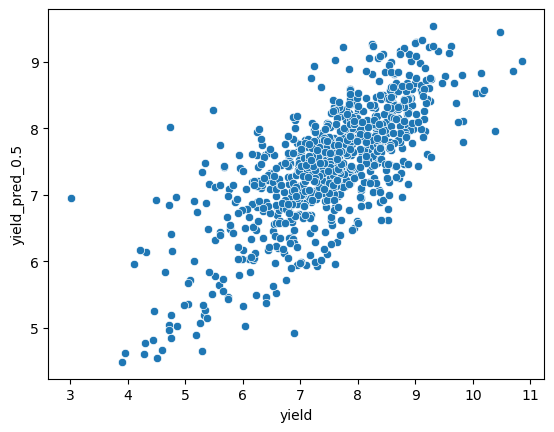

In [53]:
sns.scatterplot(data=district_df, x="yield", y="yield_pred_0.5")

<Axes: xlabel='residual', ylabel='Count'>

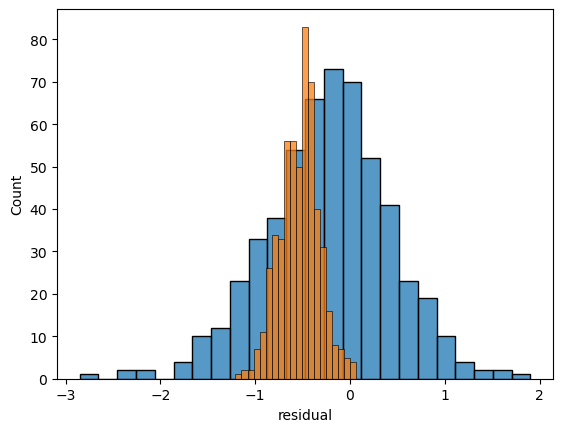

In [14]:
sns.histplot(district_df["residual"])
sns.histplot(district_df["res_pred_0.5"])

### Grid prediction


In [ ]:
# Create grid dataframe
grids_df = pd.DataFrame()
grids_df["id"] = results["grid_id"]
grids_df["year"] = results["grid_year"]
grids_df[["pred_0.1", "pred_0.5", "pred_0.9"]] = results["grid_pred"]
grids_df = pd.merge(
    left=grids_df,
    right=valid_indices_df[["id", "NUTS_ID", "NUTS_NAME"]]
    .drop_duplicates()
    .reset_index(),
    on="id",
    how="inner",
)
grids_df.drop(columns="index", inplace=True)
grids_df = pd.merge(left=grids_df, right=grids_gdf, on="id", how="inner")
grids_df = gpd.GeoDataFrame(grids_df)

print(grids_df.shape)
grids_df.head()

(95730, 8)


id  year  pred_0.1  pred_0.5  pred_0.9 NUTS_ID          NUTS_NAME  \
0  33598  2022 -0.646973  0.163452  0.820801   DE112  Baden-Württemberg   
1  35672  2022 -1.054688 -0.280029  0.916992   DE112  Baden-Württemberg   
2  35332  2022 -0.621582 -0.004429  0.770020   DE112  Baden-Württemberg   
3  35333  2022 -1.002930 -0.197510  0.878906   DE112  Baden-Württemberg   
4  34634  2022 -0.557129 -0.099854  0.735840   DE112  Baden-Württemberg   

                                            geometry  
0  POLYGON ((488293.482 5387559.119, 489015.17 53...  
1  POLYGON ((501283.863 5407559.119, 502005.551 5...  
2  POLYGON ((499118.799 5388809.119, 499840.487 5...  
3  POLYGON ((499118.799 5386309.119, 499840.487 5...  
4  POLYGON ((494788.672 5398809.119, 495510.36 54...

<Axes: xlabel='pred_0.5', ylabel='Count'>

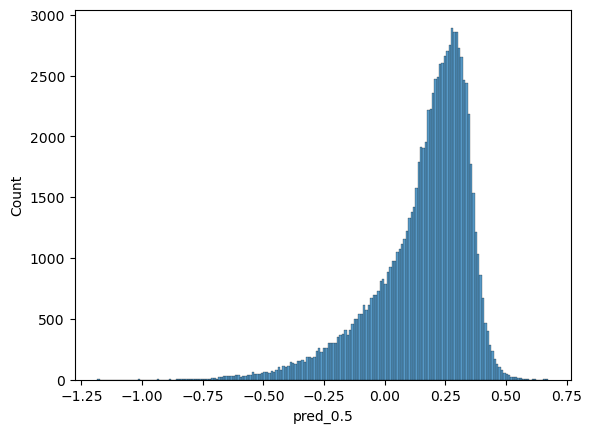

In [ ]:
sns.histplot(grids_df["pred_0.5"])

### Static weights


In [ ]:
# Create static weights dataframe
static_weights_df = pd.DataFrame()
static_weights_df["id"] = results["grid_id"]
static_weights_df["year"] = results["grid_year"]
static_variables = ["Irrigation"] + cfg.static_real_variables
static_weights_df[static_variables] = results["grids_static_sparse_weights"]
static_weights_df = pd.merge(
    left=static_weights_df,
    right=valid_indices_df[["id", "NUTS_ID", "NUTS_NAME"]]
    .drop_duplicates()
    .reset_index(),
    on="id",
    how="inner",
)
static_weights_df.drop(columns="index", inplace=True)
print(static_weights_df.shape)
static_weights_df.head()

(95730, 27)


id  year  Irrigation  SQR_MEAN   SQR_STD  SWF_area_perc  patch_density  \
0  33598  2022    0.011419  0.006977  0.003665       0.093062       0.030423   
1  35672  2022    0.010811  0.010954  0.007096       0.037504       0.018731   
2  35332  2022    0.006784  0.011621  0.005211       0.076051       0.016100   
3  35333  2022    0.009457  0.011567  0.009726       0.046010       0.022119   
4  34634  2022    0.007593  0.016678  0.004908       0.043839       0.012638   

   shape_index_mn  shannon_diversity_index  core_area_index_mn  ...  \
0        0.011888                 0.011086            0.027185  ...   
1        0.010426                 0.004353            0.057823  ...   
2        0.016269                 0.006626            0.100345  ...   
3        0.007448                 0.006277            0.059620  ...   
4        0.014074                 0.006131            0.057978  ...   

   median_dist_to_builtup  median_dist_to_grassland  median_dist_to_water  \
0                0.067736                  0.062920              0.011211   
1                0.099757                  0.036192              0.017150   
2                0.053416                  0.058726              0.016494   
3                0.053543                  0.061043              0.010078   
4                0.085845                  0.057885              0.010396   

   median_dist_to_tree_cover  elevation_mean  slope_mean  elevation_std  \
0                   0.038098        0.015625    0.021930       0.038117   
1                   0.046679        0.015098    0.014628       0.051911   
2                   0.022623        0.016078    0.013366       0.023446   
3                   0.019121        0.008757    0.010742       0.022463   
4                   0.035640        0.016367    0.014475       0.073145   

   slope_std  NUTS_ID          NUTS_NAME  
0   0.018641    DE112  Baden-Württemberg  
1   0.017639    DE112  Baden-Württemberg  
2   0.016611    DE112  Baden-Württemberg  
3   0.024366    DE112  Baden-Württemberg  
4   0.016446    DE112  Baden-Württemberg  

[5 rows x 27 columns]

### Visualization


#### Plot the global validation metrics


/tmp/ipykernel_3435232/1434438952.py:10: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


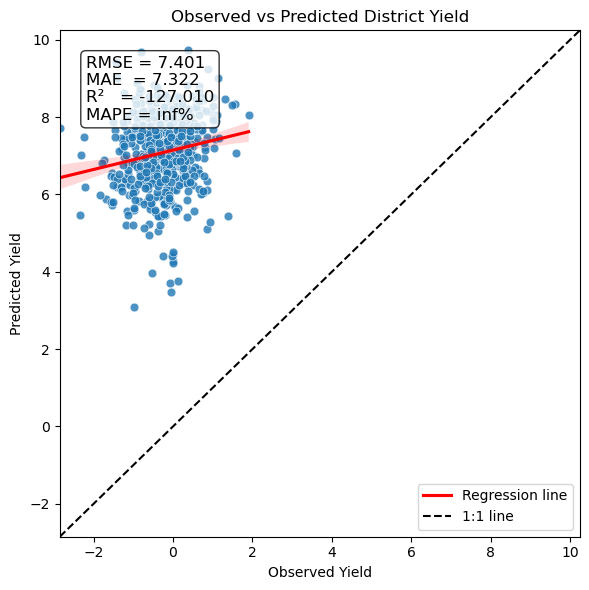

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = district_df["yield"].values
y_pred = district_df["yield_pred_0.5"].values

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred, s=40, edgecolor="white", alpha=0.8)
sns.regplot(x=y_true, y=y_pred, scatter=False, color="red", label="Regression line")
# 1:1 line
lims = [min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred)) + 0.5]
plt.plot(lims, lims, "--", color="black", label="1:1 line", linewidth=1.5)
plt.xlim(lims)
plt.ylim(lims)

# Text box with metrics
metrics_text = (
    f"RMSE = {rmse:.3f}\n"
    f"MAE  = {mae:.3f}\n"
    f"R²   = {r2:.3f}\n"
    f"MAPE = {mape:.2f}%"
)
plt.text(
    0.05,
    0.95,
    metrics_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)

# Labels
plt.xlabel("Observed Yield")
plt.ylabel("Predicted Yield")
plt.title("Observed vs Predicted District Yield")
plt.legend()
plt.tight_layout()
plt.show()

#### Plot the data for a single year


In [ ]:
# Define the year to visualize
year = 2022

district_df_filtered = district_df[district_df["year"] == year]
grids_df_filtered = grids_df[grids_df["year"] == year]

static_weights_df_filtered = static_weights_df[static_weights_df["year"] == year]
static_weights_df_filtered = pd.merge(
    left=static_weights_df_filtered, right=grids_gdf, on="id", how="inner"
)
static_weights_df_filtered = gpd.GeoDataFrame(static_weights_df_filtered)

print(
    district_df_filtered.shape,
    grids_df_filtered.shape,
    static_weights_df_filtered.shape,
)

(270, 17) (47800, 8) (47800, 28)


In [ ]:
grids_df_filtered["pred_0.5"].mean()

np.float64(0.10486485168275474)

In [88]:
district_df_filtered

NUTS_ID  year  yield  baseline_yield  residual  res_pred_0.1  \
0     DE112  2022   8.19           8.487    -0.297     -0.770280   
2     DE113  2022   9.12           7.534     1.586     -0.843288   
4     DE114  2022   8.25           7.933     0.317     -0.785037   
6     DE115  2022   7.35           7.380    -0.030     -1.011646   
8     DE116  2022   6.31           7.141    -0.831     -0.829295   
..      ...   ...    ...             ...       ...           ...   
532   DEG0G  2022   7.12           7.670    -0.550     -0.857081   
534   DEG0J  2022   6.16           7.411    -1.251     -0.895485   
536   DEG0K  2022   5.69           7.926    -2.236     -0.791046   
538   DEG0L  2022   6.64           8.114    -1.474     -0.845418   
540   DEG0M  2022   8.38           8.729    -0.349     -0.825288   

     res_pred_0.5  res_pred_0.9  yield_pred_0.1  yield_pred_0.5  \
0       -0.010522      0.874029        7.716721        8.476479   
2       -0.004761      0.888083        6.690711        7.529239   
4        0.124693      0.873256        7.147963        8.057693   
6       -0.187596      0.768791        6.368354        7.192404   
8        0.103356      0.885480        6.311705        7.244356   
..            ...           ...             ...             ...   
532     -0.108350      0.861839        6.812919        7.561650   
534      0.027357      0.891849        6.515514        7.438356   
536      0.077451      0.877728        7.134954        8.003451   
538      0.068909      0.893696        7.268582        8.182909   
540      0.108552      0.911199        7.903712        8.837553   

     yield_pred_0.9  total_loss  quantile_loss  spatial_loss  \
0          9.361030    0.347541       0.307670      0.079743   
2          8.422083    1.695271       1.666435      0.057673   
4          8.806256    0.323701       0.261983      0.123437   
6          8.148790    0.313206       0.256842      0.112728   
8          8.026480    0.665291       0.640361      0.049860   
..              ...         ...            ...           ...   
532        8.531839    0.472269       0.392717      0.159105   
534        8.302849    1.213579       1.173427      0.080305   
536        8.803728    2.825787       2.768557      0.114461   
538        9.007696    1.627389       1.573948      0.106882   
540        9.640200    0.467927       0.402425      0.131005   

                                              geometry          NUTS_NAME  \
0    POLYGON ((998079.933 6246033.717, 998333.568 6...  Baden-Württemberg   
2    MULTIPOLYGON (((1047573.532 6236745.359, 10481...  Baden-Württemberg   
4    POLYGON ((1067374.242 6237794.455, 1067772.653...  Baden-Württemberg   
6    MULTIPOLYGON (((1047783.485 6282427.299, 10463...  Baden-Württemberg   
8    POLYGON ((1057632.793 6288276.76, 1058369.595 ...  Baden-Württemberg   
..                                                 ...                ...   
532  POLYGON ((1291491.733 6641460.252, 1293178.768...          Thüringen   
534  POLYGON ((1302477.03 6635316.357, 1302703.897 ...          Thüringen   
536  POLYGON ((1317129.861 6583449.818, 1319302.152...          Thüringen   
538  POLYGON ((1356670.36 6615925.166, 1357913.096 ...          Thüringen   
540  POLYGON ((1375024.1 6638325.946, 1375440.957 6...          Thüringen   

     deviation  
0    -0.286479  
2     1.590761  
4     0.192307  
6     0.157596  
8    -0.934356  
..         ...  
532  -0.441650  
534  -1.278357  
536  -2.313451  
538  -1.542909  
540  -0.457553  

[270 rows x 17 columns]

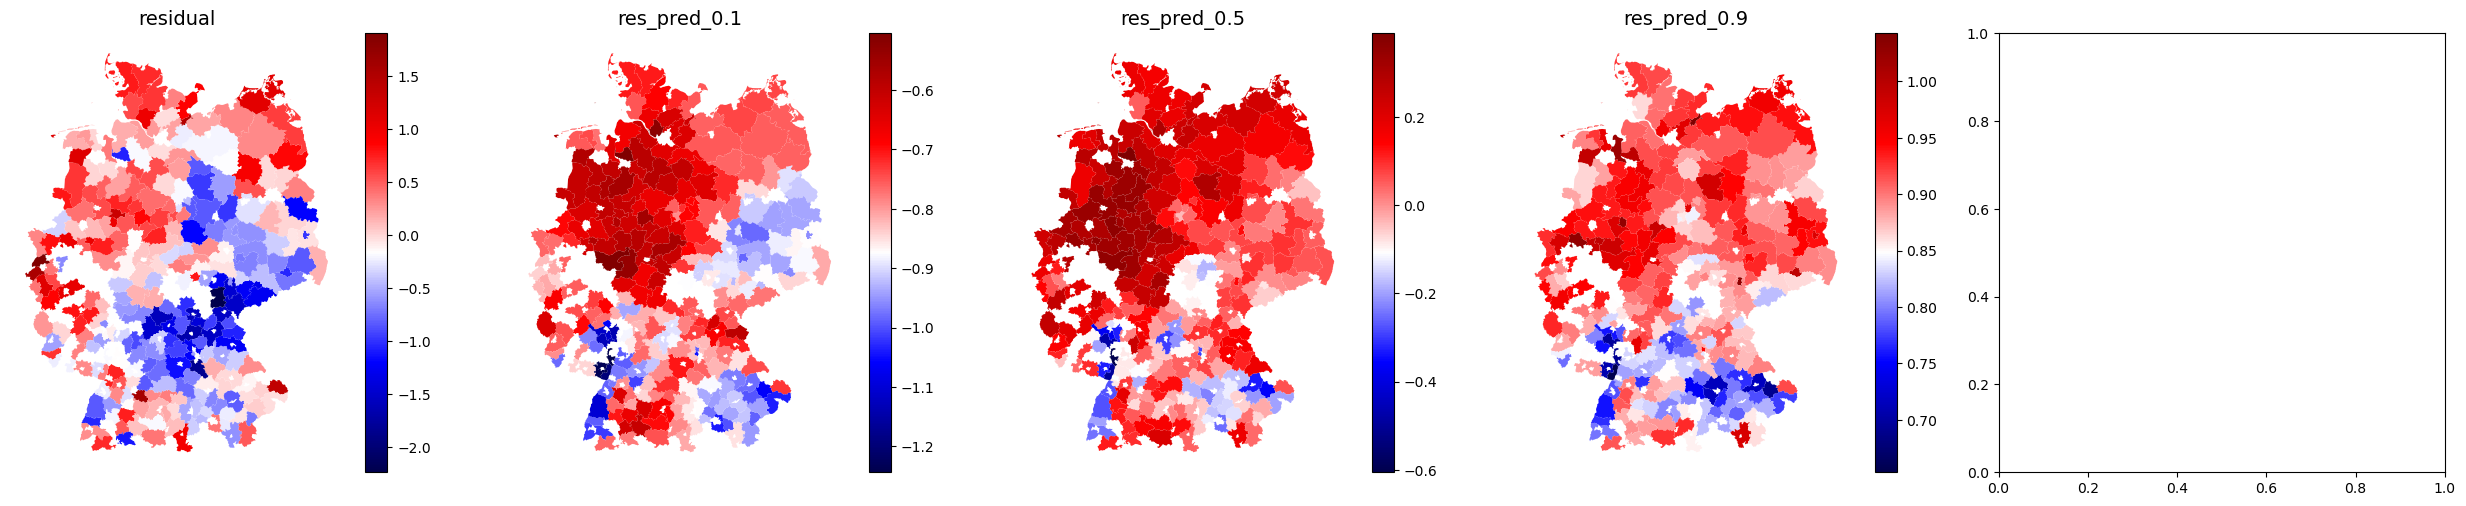

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

vars_to_plot = ["residual", "res_pred_0.1", "res_pred_0.5", "res_pred_0.9"]

# Compute common vmin/vmax for yield-related maps
yield_vars = ["residual", "res_pred_0.1", "res_pred_0.5", "res_pred_0.9"]
vmin = None
vmax = None

# ----- deviation threshold -----
threshold = 0.1  # adjust if needed

# ----- Custom color map -----
colors = [
    ("red"),  # strong negative
    ("lightgrey"),  # low deviation
    ("green"),  # strong positive
]

cmap_dev = mcolors.LinearSegmentedColormap.from_list("dev_map", colors, N=256)

# ----- Normalize deviation to [-1, 1] but keep grey in middle -----
norm_dev = mcolors.TwoSlopeNorm(
    vmin=-district_df_filtered["deviation"].abs().max(),
    vcenter=0,
    vmax=district_df_filtered["deviation"].abs().max(),
)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):

    if var == "deviation":
        # classify deviation into grey if small
        dev_vals = district_df_filtered["deviation"].copy()

        # Create a temporary column to override colors
        temp_col = dev_vals.copy()

        # Replace small deviations with 0 (center → grey zone)
        temp_col[dev_vals.abs() < threshold] = 0

        # Plot deviation field
        district_df_filtered.assign(_dev=temp_col).plot(
            column="_dev", ax=axes[i], cmap=cmap_dev, norm=norm_dev, legend=True
        )
    else:
        district_df_filtered.plot(
            column=var, ax=axes[i], cmap="seismic", vmin=vmin, vmax=vmax, legend=True
        )

    axes[i].set_title(var, fontsize=14)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

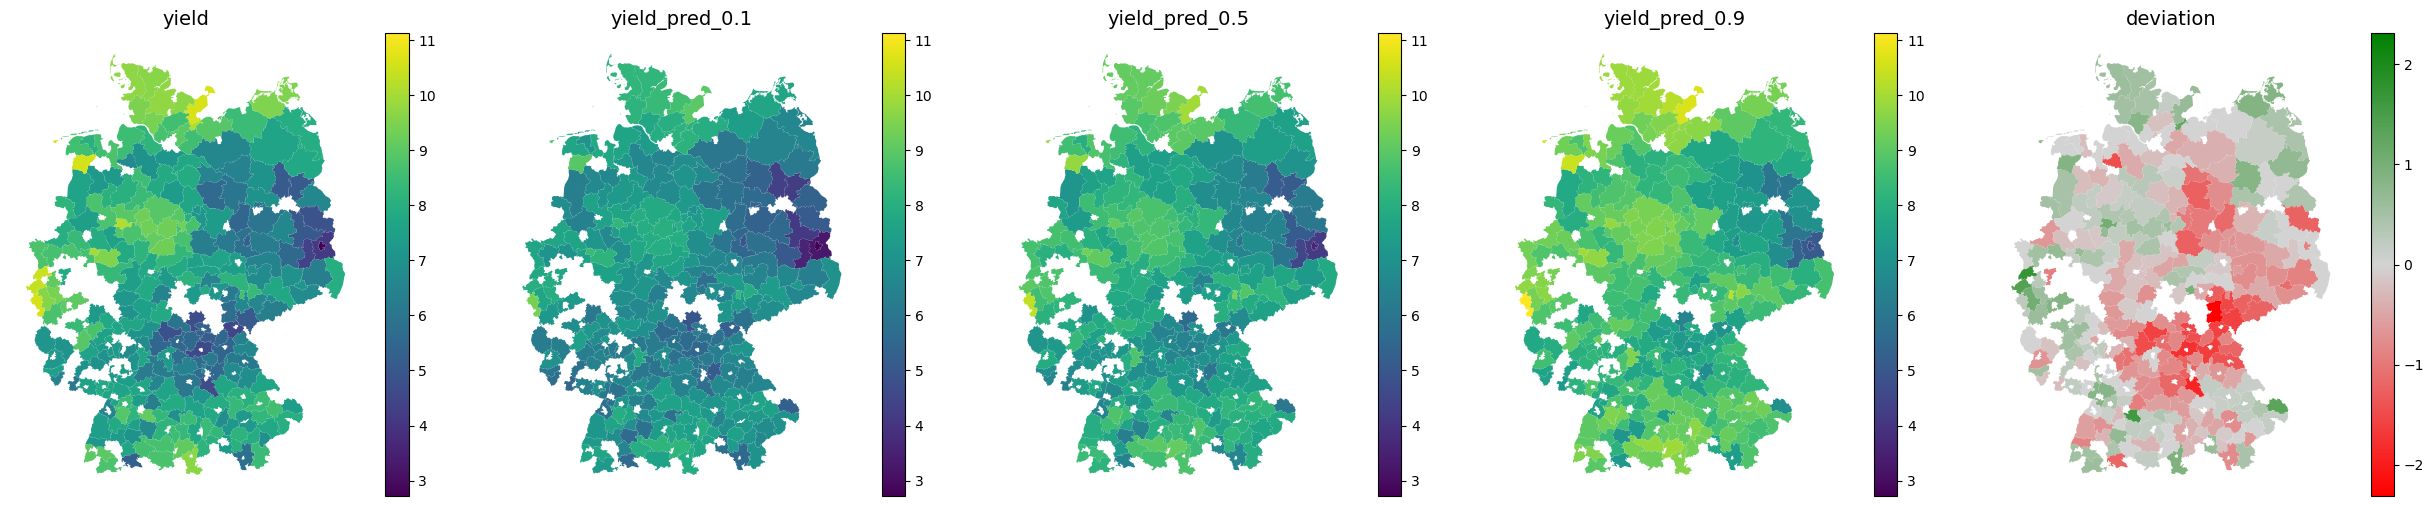

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

vars_to_plot = [
    "yield",
    "yield_pred_0.1",
    "yield_pred_0.5",
    "yield_pred_0.9",
    "deviation",
]

# Compute common vmin/vmax for yield-related maps
yield_vars = ["yield", "yield_pred_0.1", "yield_pred_0.5", "yield_pred_0.9"]
vmin = float(district_df_filtered[yield_vars].min().min())
vmax = float(district_df_filtered[yield_vars].max().max())

# ----- deviation threshold -----
threshold = 0.1  # adjust if needed

# ----- Custom color map -----
colors = [
    ("red"),  # strong negative
    ("lightgrey"),  # low deviation
    ("green"),  # strong positive
]

cmap_dev = mcolors.LinearSegmentedColormap.from_list("dev_map", colors, N=256)

# ----- Normalize deviation to [-1, 1] but keep grey in middle -----
norm_dev = mcolors.TwoSlopeNorm(
    vmin=-district_df_filtered["deviation"].abs().max(),
    vcenter=0,
    vmax=district_df_filtered["deviation"].abs().max(),
)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):

    if var == "deviation":
        # classify deviation into grey if small
        dev_vals = district_df_filtered["deviation"].copy()

        # Create a temporary column to override colors
        temp_col = dev_vals.copy()

        # Replace small deviations with 0 (center → grey zone)
        temp_col[dev_vals.abs() < threshold] = 0

        # Plot deviation field
        district_df_filtered.assign(_dev=temp_col).plot(
            column="_dev", ax=axes[i], cmap=cmap_dev, norm=norm_dev, legend=True
        )
    else:
        district_df_filtered.plot(
            column=var, ax=axes[i], cmap="viridis", vmin=vmin, vmax=vmax, legend=True
        )

    axes[i].set_title(var, fontsize=14)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

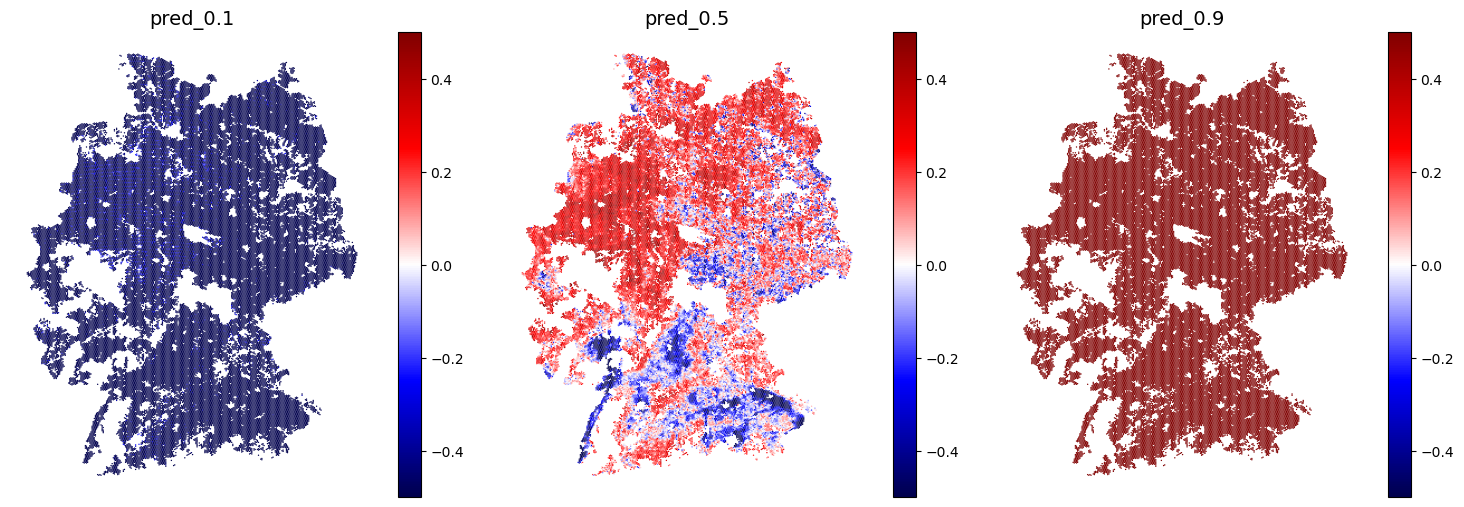

In [ ]:
vars_to_plot = ["pred_0.1", "pred_0.5", "pred_0.9"]

# Compute common vmin/vmax for yield-related maps
yield_vars = ["pred_0.1", "pred_0.5", "pred_0.9"]
vmin = float(grids_df_filtered[yield_vars].min().min())
vmax = float(grids_df_filtered[yield_vars].max().max())

vmin = -0.5
vmax = 0.5

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):

    if var == "deviation":
        grids_df_filtered.plot(column=var, ax=axes[i], cmap="RdYlGn", legend=True)
    else:
        grids_df_filtered.plot(
            column=var, ax=axes[i], cmap="seismic", vmin=vmin, vmax=vmax, legend=True
        )

    axes[i].set_title(var, fontsize=14)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

<Axes: >

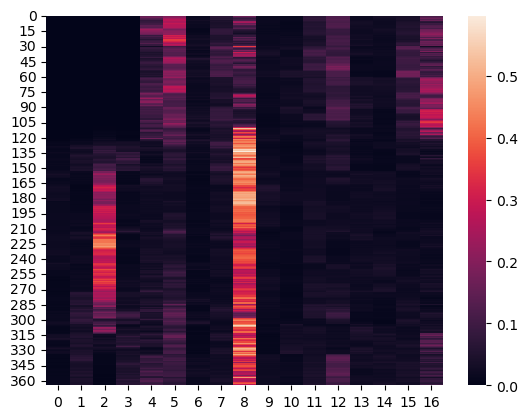

In [ ]:
sns.heatmap(results["district_encoder_sparse_weights"].mean(axis=0))

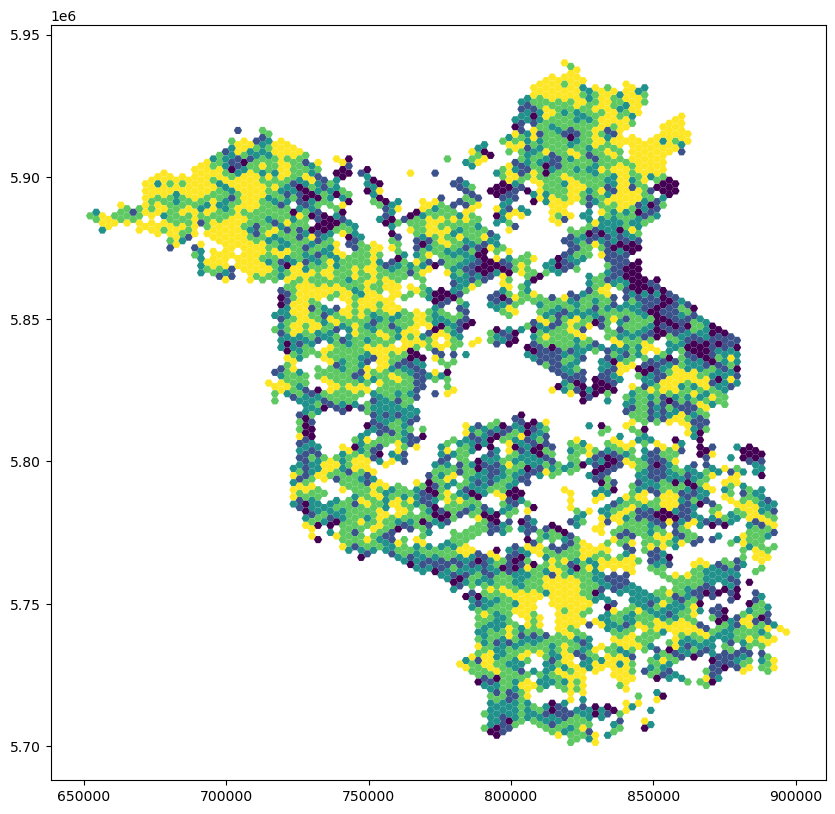

In [ ]:
grids_df_filtered[grids_df_filtered["NUTS_NAME"] == "Brandenburg"].plot(
    column="pred_0.5", scheme="NaturalBreaks", figsize=(10, 10)
)

<Axes: >

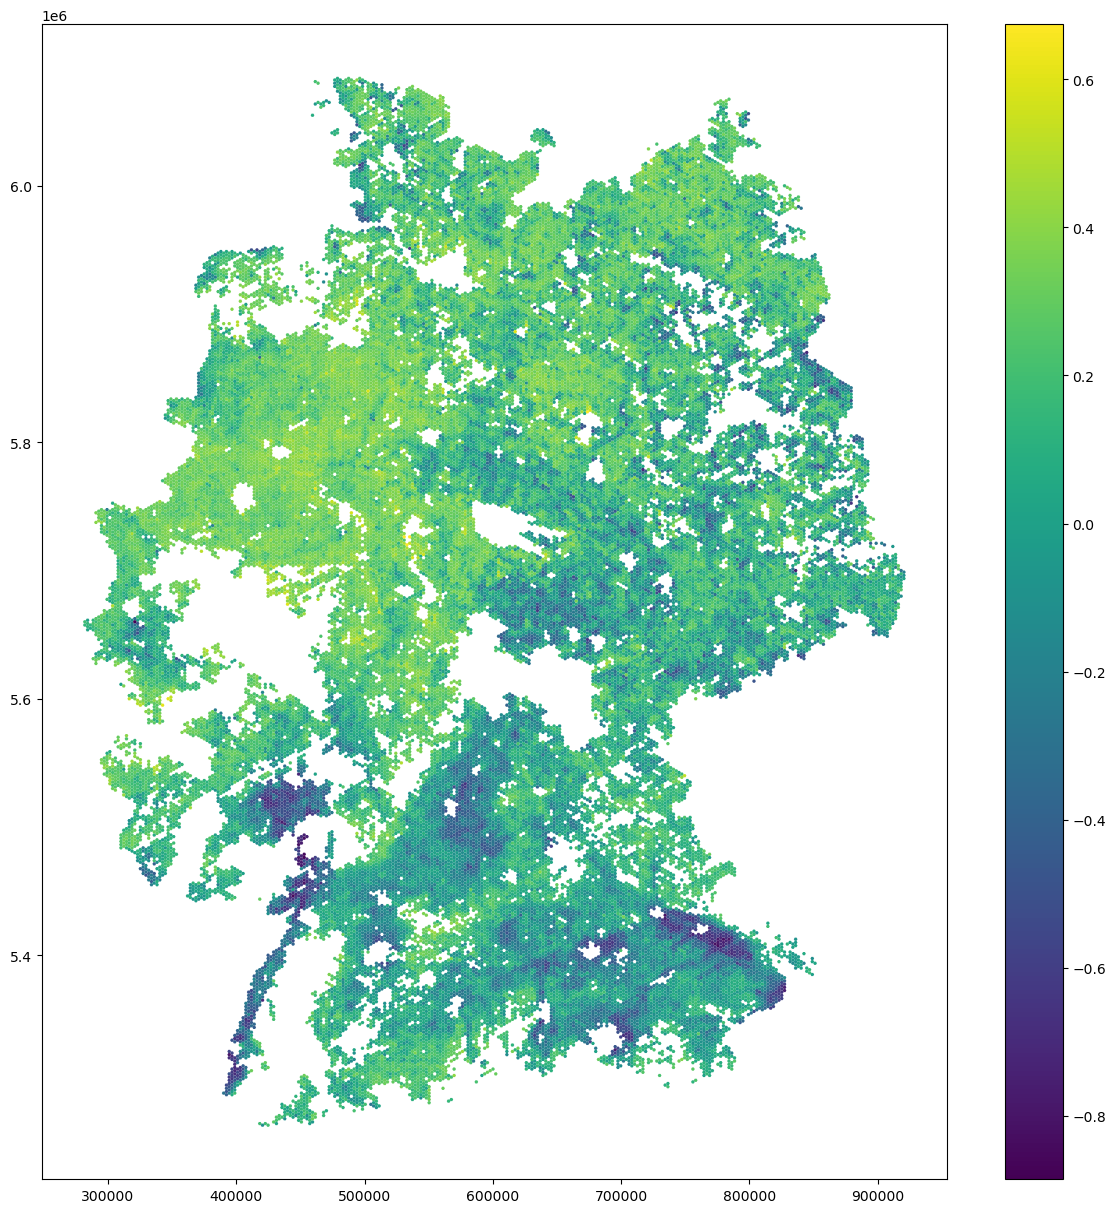

In [ ]:
grids_df_filtered.plot(column="pred_0.5", figsize=(15, 15), legend=True)

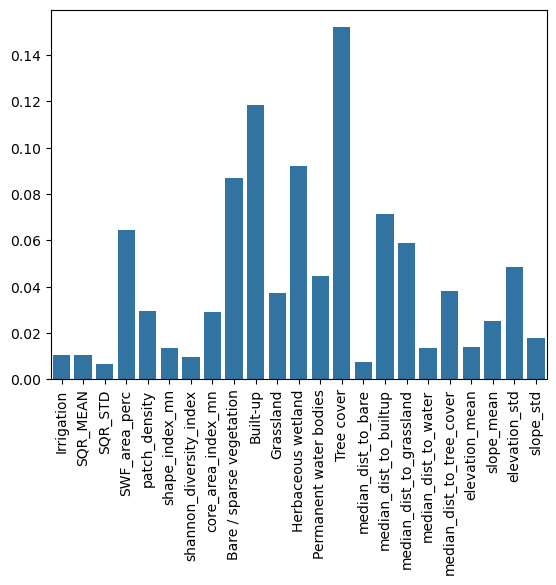

In [ ]:
sns.barplot(static_weights_df_filtered.iloc[:, 2:-3].mean(axis=0))
plt.xticks(rotation=90)

plt.show()

<Axes: >

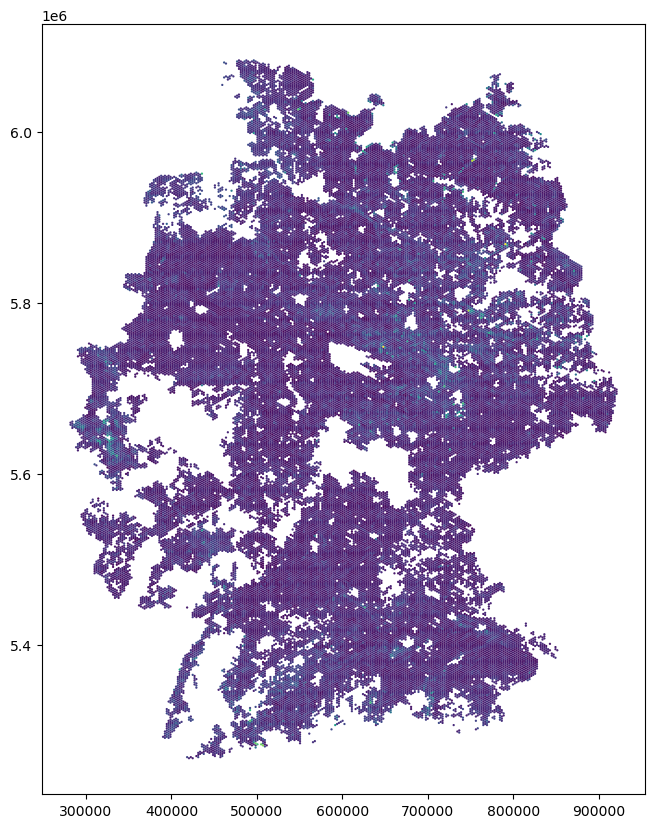

In [ ]:
static_weights_df_filtered.plot(column="median_dist_to_bare", figsize=(10, 10))